# Face Recognition

In this notebook we are going to create and train a model for the problem of face recognition. The first step is to create and visualize the dataset, that is going to be the LFW dataset. Next, we are going to pretrain a model to classify those faces, and finally, that pretrained model is what we are going to use as a baseline to create a siamese neural network to solve this face recognition problem. 

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image as Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms

from glob import glob
from tqdm.notebook import tqdm

import os
import sys
import copy

## First, lets create our dataset and visualize the images

In [2]:
class LFWDataset(Dataset):
    def __init__(self, train=True, trans=None):    
        if trans is not None:
            self.transforms = trans
        else:
            self.transforms = transforms.ToTensor()
            
        data_path = "/media/carlo/16CA983262CDA30A/Datasets/lfw/*"
        identities_directories = glob(data_path)
        
        # here, we are going to store all the paths to the images
        images = []
        
        # the identities are the names of the persons, we need to create a class
        # for each one in order to train the neural network
        self.identities_to_labels = {}

        # create labels and define the paths to the images
        for idx, directory in enumerate(identities_directories):
            # get the name of the person of the current folder
            identity = directory.split(os.sep)[-1]
            
            # assign they a class
            self.identities_to_labels[identity] = idx

            # get all the images files in the directory
            images_path = glob(directory + os.sep + "*")
            
            images += images_path
        
        # splitting in train and test
        train_images, test_images = train_test_split(images)
        
        if train:
            self.images = train_images
        else:
            self.images = test_images
        
 
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        image = self.transforms(image)
        
        # get the name of the person
        identity = image_path.split(os.sep)[-2]
        
        label = self.identities_to_labels[identity]
        
        return image, label
    
    def __len__(self):
        return len(self.images)

Now, lets define our train and test transformers. For train, we are going to use data augmentation to avoid overtraining

In [3]:
IMG_HEIGHT, IMG_WIDTH = 300, 300

train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = LFWDataset(True, train_transforms)
test_dataset = LFWDataset(False, test_transforms)

Now, lets plot some images to see the results

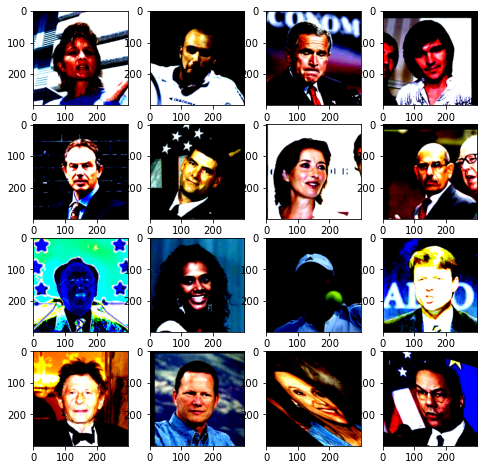

In [4]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = train_dataset[i][0].numpy()
    img = np.moveaxis(img, 0, 2)
    img = np.clip(img, 0, 1)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

The color issues are due to the normalization

Lets create a virtual dataloader to handle virtual epochs due to the large dataset

In [5]:
class VirtualDataLoader:

    def __init__(self, data_loader, steps_per_epoch: int = 1000):
        self.data_loader = data_loader
        self.iterator = iter(self.data_loader)
        self.steps_per_epoch = steps_per_epoch
        self.current_step = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_step < self.steps_per_epoch:
            self.current_step += 1
            try:
                return next(self.iterator)
            except StopIteration:
                self.iterator = iter(self.data_loader)
                return next(self.iterator)
        else:
            self.current_step = 0
            raise StopIteration
            
    def __len__(self):
        return self.steps_per_epoch

And now, create the data loaders

In [6]:
BATCH_SIZE = 25
TRAIN_STEPS_PER_EPOCH = 1000
TEST_STEPS_PER_EPOCH = 500
EPOCHS = 30
MODEL_DIR = "./models/v2/"

raw_train_loader = DataLoader(
    train_dataset,
    BATCH_SIZE,
    shuffle=True,
    num_workers=14
)

raw_test_loader = DataLoader(
    test_dataset,
    BATCH_SIZE,
    num_workers=14
)

train_loader = VirtualDataLoader(raw_train_loader, TRAIN_STEPS_PER_EPOCH)
test_loader = VirtualDataLoader(raw_test_loader, TEST_STEPS_PER_EPOCH)

## Pretraining

In [7]:
# Get the number of labels 
labels = max(train_dataset.identities_to_labels.values()) + 1
labels

5749

Now, lets create the model to pretrain

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.efficientnet_b3(pretrained=True).to(device)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=labels, bias=True)
).to(device)

Lets define our train function

In [9]:
def train(model: torch.nn.Module, train_set, test_set, epochs_, step, learning_rate, model_name: str,
          path_to_save: str, start_epoch_=0, adam: bool = True, patience: int = 5):
    """
    Train a siamese network with Adam or RMSProp optimizer and contrastive loss.
    :param model: torch.nn.Module
        The Pytorch model to train
    :param train_set: DataLoader
        The data to train the model
    :param test_set: DataLoader
        The data to test the efficiency of the model
    :param epochs_: int
        The number of epochs to train. If -1, it will train until the early stopping stops the training
    :param step: function
        A function that receives a data sample from the dataset and returns the loss
    :param learning_rate: float
        Starting learning rate used during the train phase
    :param model_name: str
        Specify the model name, just to save the files correctly
    :param path_to_save: str
        The path to save the model
    :param start_epoch_: int
        To continue the training. Indicates in what epoch the current train will start.
    :param adam: bool
        If true, uses Adam as optimizer, if false uses RMSProp
    :param patience: int
        The number of epochs used in the early stopping
    :return: (list, list)
        The train and test losses
    """
    losses_ = []
    test_losses_ = []
    accuracies = []
    test_accuracies = []
    
    best_score = float("inf")
    best_model = None
    not_improved = 0
    until_converge = False

    if adam:
        optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    if start_epoch_ != 0:
        lr_scheduler.load_state_dict(torch.load(f"{path_to_save}/lr_scheduler_{start_epoch_ - 1}.pt"))

    if epochs_ == -1:
        epochs_ = start_epoch_ + 1
        until_converge = True
        
    # to scale and train in fp16
    scaler = torch.cuda.amp.GradScaler()

    epoch = start_epoch_
    while epoch < epochs_:
        sys.stdout.flush()
        model.train()
        epoch_loss = 0
        epoch_acc = 0

        for sample in tqdm(train_set, total=len(train_set), desc='Train'):
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                current_loss, current_acc = step(model, *sample)
            
            scaler.scale(current_loss).backward()

            epoch_loss += current_loss.detach().cpu().item()
            epoch_acc += current_acc

            scaler.step(optimizer)
            scaler.update()

        # Test step
        model.eval()
        sys.stdout.flush()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for sample in tqdm(test_set, total=len(test_set), desc="Test"):
                current_loss, current_acc = step(model, *sample)
                test_loss += current_loss.detach().cpu().item()
                test_acc += current_acc
                

        epoch_loss /= len(train_set)
        test_loss /= len(test_set)
        
        epoch_acc /= len(train_set)
        test_acc /= len(test_set)
        
        losses_.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        test_losses_.append(test_loss)
        test_accuracies.append(test_acc)

        torch.save(model.state_dict(), f'{path_to_save}/{model_name}.pt')
        torch.save(lr_scheduler.state_dict(), f'{path_to_save}/lr_scheduler.pt')

        # Get the best model
        if test_loss < best_score:
            best_score = test_loss
            best_model = copy.deepcopy(model.state_dict())
            not_improved = 0

        else:
            not_improved += 1

        if until_converge:
            epochs_ += 1
            message = f'Epoch: {epoch + 1}, '
            full_message = f'Epoch: {epoch + 1}, '
    
        else:
            message = f'Epoch: {epoch + 1}/{epochs_}, '
            full_message = f'Epoch: {epoch + 1}/{epochs_}, '

        message += f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} ' + \
                      f'Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f} ' + \
                      f'Epochs w/o improvement: {not_improved}\n'

        full_message += f'Loss: {epoch_loss}, Acc: {epoch_acc} ' + \
                           f'Test loss: {test_loss}, Test acc: {test_acc} ' + \
                           f'Epochs w/o improvement: {not_improved}\n'

        sys.stdout.flush()
        sys.stdout.write(message)

        with open(f'{path_to_save}/train_{model_name}.log', 'a') as f:
            f.write(full_message)
            f.close()

        # Early stopping
        if not_improved == patience:
            break

        epoch += 1

    torch.save(best_model, f'{path_to_save}/best-{model_name}.pt')
    return losses_, test_losses_, accuracies, test_accuracies

A function to calculate the accuracy, we are gonig to use it later in our training

In [10]:
def get_accuracy(predictions, labels):
    predicted_classes = np.argmax(predictions, axis=-1)
    return accuracy_score(labels, predicted_classes)

And implement a step of the face classification training process

In [11]:
def classification_train_step(model, images, labels):
    images = images.to(device)
    labels = labels.to(device)

    predictions = model(images)

    return F.cross_entropy(predictions, labels), get_accuracy(
        predictions.detach().cpu().numpy(),
        labels.detach().cpu().numpy())

In [12]:
losses, test_losses, accuracies, test_accuracies = train(
    model=model,
    train_set=train_loader,
    test_set=test_loader,
    epochs_=EPOCHS,
    step=classification_train_step,
    learning_rate=0.001,
    model_name="b3_classification",
    path_to_save=MODEL_DIR,
    patience=-1
)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 6.9784, Acc 0.1291 Test loss: 4.9654, Test acc: 0.3127 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 3.8845, Acc 0.3823 Test loss: 2.2210, Test acc: 0.7846 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.8375, Acc 0.8312 Test loss: 2.0223, Test acc: 0.8424 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.2842, Acc 0.9399 Test loss: 2.0680, Test acc: 0.8470 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.2053, Acc 0.9529 Test loss: 2.1229, Test acc: 0.8446 Epochs w/o improvement: 2


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.1893, Acc 0.9552 Test loss: 2.1156, Test acc: 0.8434 Epochs w/o improvement: 3


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.1493, Acc 0.9636 Test loss: 2.1391, Test acc: 0.8502 Epochs w/o improvement: 4


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.1305, Acc 0.9681 Test loss: 2.1376, Test acc: 0.8484 Epochs w/o improvement: 5


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.1123, Acc 0.9714 Test loss: 2.2031, Test acc: 0.8492 Epochs w/o improvement: 6


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.1122, Acc 0.9719 Test loss: 2.2322, Test acc: 0.8477 Epochs w/o improvement: 7


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.0996, Acc 0.9751 Test loss: 2.3241, Test acc: 0.8488 Epochs w/o improvement: 8


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.0897, Acc 0.9774 Test loss: 2.3093, Test acc: 0.8546 Epochs w/o improvement: 9


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.0901, Acc 0.9772 Test loss: 2.4537, Test acc: 0.8516 Epochs w/o improvement: 10


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.0726, Acc 0.9802 Test loss: 2.4981, Test acc: 0.8529 Epochs w/o improvement: 11


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.0690, Acc 0.9823 Test loss: 2.4475, Test acc: 0.8561 Epochs w/o improvement: 12


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.0726, Acc 0.9818 Test loss: 2.4217, Test acc: 0.8546 Epochs w/o improvement: 13


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.0716, Acc 0.9816 Test loss: 2.4389, Test acc: 0.8507 Epochs w/o improvement: 14


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.0592, Acc 0.9852 Test loss: 2.4044, Test acc: 0.8500 Epochs w/o improvement: 15


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.0614, Acc 0.9846 Test loss: 2.3718, Test acc: 0.8561 Epochs w/o improvement: 16


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.0589, Acc 0.9842 Test loss: 2.4163, Test acc: 0.8542 Epochs w/o improvement: 17


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.0519, Acc 0.9871 Test loss: 2.2894, Test acc: 0.8561 Epochs w/o improvement: 18


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.0554, Acc 0.9859 Test loss: 2.3068, Test acc: 0.8515 Epochs w/o improvement: 19


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.0541, Acc 0.9860 Test loss: 2.4122, Test acc: 0.8529 Epochs w/o improvement: 20


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.0431, Acc 0.9885 Test loss: 2.3896, Test acc: 0.8534 Epochs w/o improvement: 21


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.0485, Acc 0.9879 Test loss: 2.3735, Test acc: 0.8526 Epochs w/o improvement: 22


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.0439, Acc 0.9888 Test loss: 2.4352, Test acc: 0.8507 Epochs w/o improvement: 23


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.0418, Acc 0.9894 Test loss: 2.5180, Test acc: 0.8541 Epochs w/o improvement: 24


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.0421, Acc 0.9893 Test loss: 2.4639, Test acc: 0.8524 Epochs w/o improvement: 25


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.0400, Acc 0.9898 Test loss: 2.3501, Test acc: 0.8523 Epochs w/o improvement: 26


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.0378, Acc 0.9902 Test loss: 2.4228, Test acc: 0.8537 Epochs w/o improvement: 27


Check the performance of the model

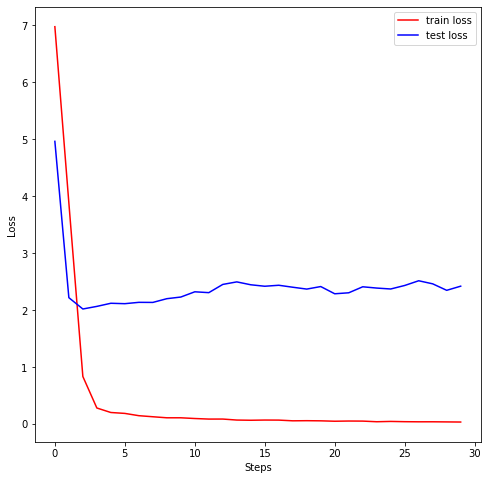

In [13]:
plt.figure(figsize=(8, 8))
plt.plot(losses, c='red', label='train loss')
plt.plot(test_losses, c='blue', label='test loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

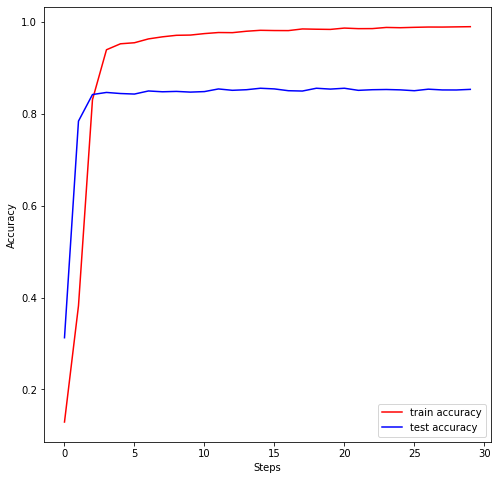

In [14]:
plt.figure(figsize=(8, 8))
plt.plot(accuracies, c='red', label='train accuracy')
plt.plot(test_accuracies, c='blue', label='test accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Face recognition

Once we have our pretrained model, now lets train the model for the face recognition problem, we are going to use a siamese neural network trained with the triplet loss. The first thing we are going to do is to create the database for this specific problem

In [15]:
class TripletCelebADataset(Dataset):
    def __init__(self, mode='train', trans=None):
        if trans is not None:
            self.transforms = trans
        else:
            self.transforms = transforms.ToTensor()
        
        data_path = "/media/carlo/16CA983262CDA30A/Datasets/CelebA/"
        self.images_path = data_path + "img_align_celeba/"
        identities_table = pd.read_csv(data_path + "identity_CelebA.csv").values
        
        # create a dictonary to get the identities easier
        self.inverse_identities = {}
        for image_name, label in identities_table:
            # the labels in the table are base 1, the -1 is to make it base 0
            if label - 1 in self.inverse_identities:
                self.inverse_identities[label - 1].append(image_name)
            else:
                self.inverse_identities[label - 1] = [image_name]

        # split in train and test
        np.random.seed(512)
        siamese_data, predictor_data = train_test_split(list(self.inverse_identities.keys()))
        train_identities, test_identities = train_test_split(siamese_data)
        
        if mode == 'train':
            self.identities = train_identities
        elif mode == 'test':
            self.identities = test_identities
        elif mode == 'predictor':
            self.identities = predictor_data
        else:
            raise Exception("No mode difined")
            
    def __getitem__(self, index):
        anchor_path = None
        positive_path = None
        negative_path = None
        
        # repeat this until find a anchor that has 2 or more images
        while anchor_path is None:
            anchor_candidate = np.random.choice(self.identities)
            
            if len(self.inverse_identities[anchor_candidate]) > 1:
                anchor_path = np.random.choice(self.inverse_identities[anchor_candidate])
                
        # look for a positive image
        while positive_path is None:
            positive_candidate = np.random.choice(self.inverse_identities[anchor_candidate])

            if anchor_path != positive_candidate:
                positive_path = positive_candidate
                
        # look for the negative image
        while negative_path is None:
            negative_candidate = np.random.choice(self.identities)

            if negative_path != anchor_candidate:
                negative_path = np.random.choice(self.inverse_identities[negative_candidate])
                
        # loads images
        anchor_image = Image.open(self.images_path + anchor_path)
        positive_image = Image.open(self.images_path + positive_path)
        negative_image = Image.open(self.images_path + negative_path)
        
        # transforms the images
        anchor_image = self.transforms(anchor_image)
        positive_image = self.transforms(positive_image)
        negative_image = self.transforms(negative_image)
        
        return anchor_image, positive_image, negative_image
        
    
    def __len__(self):
        return len(self.identities)

In [16]:
train_dataset = TripletCelebADataset("train", train_transforms)
test_dataset = TripletCelebADataset("test", test_transforms)

Lets visualize the dataset

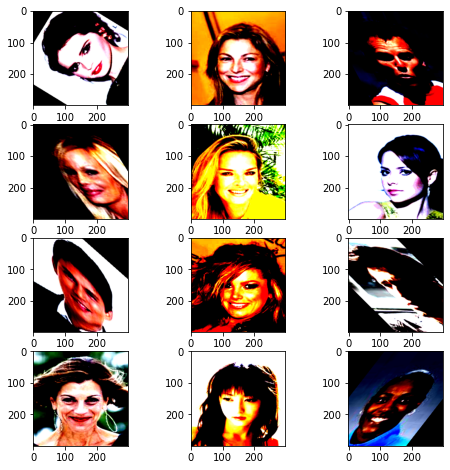

In [17]:
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(1, rows +1):
    anchor = train_dataset[i][0].numpy()
    anchor = np.moveaxis(anchor, 0, 2)
    anchor = np.clip(anchor, 0, 1)
    fig.add_subplot(rows, columns, (i - 1) * 3 + 1)
    plt.imshow(anchor)
    
    positive = train_dataset[i][1].numpy()
    positive = np.moveaxis(positive, 0, 2)
    positive = np.clip(positive, 0, 1)
    fig.add_subplot(rows, columns, (i - 1) * 3 + 2)
    plt.imshow(positive)
    
    negative = train_dataset[i][0].numpy()
    negative = np.moveaxis(negative, 0, 2)
    negative = np.clip(negative, 0, 1)
    fig.add_subplot(rows, columns, (i - 1) * 3 + 3)
    plt.imshow(negative)
plt.show()

In [18]:
BATCH_SIZE = 25
TRAIN_STEPS_PER_EPOCH = 1000
TEST_STEPS_PER_EPOCH = 500
EPOCHS = 30

raw_train_loader = DataLoader(
    train_dataset,
    BATCH_SIZE,
    shuffle=True,
    num_workers=14
)

raw_test_loader = DataLoader(
    test_dataset,
    BATCH_SIZE,
    num_workers=14
)

train_loader = VirtualDataLoader(raw_train_loader, TRAIN_STEPS_PER_EPOCH)
test_loader = VirtualDataLoader(raw_test_loader, TEST_STEPS_PER_EPOCH)

In [19]:
LATENT_DIM = 4096

# get the model that had the best performance in the classification task
# but first we need to recreate it
model = models.efficientnet_b3(pretrained=True).to(device)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=labels, bias=True)
).to(device)

model.load_state_dict(torch.load(f"{MODEL_DIR}best-b3_classification.pt"))

# freezing the weights
for parameter in model.parameters():
    parameter.requires_grad = False

# replacing the last layer to get the latent space
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1536, out_features=LATENT_DIM, bias=True)
).to(device)

define the new training step for siamese networks

In [20]:
def siamese_train_step(model, anchor, positive, negative):
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)
    
    anchor_features = model(anchor)
    positive_features = model(positive)
    negative_features = model(negative)
    
    # the last 0 is for the accuracy part, which we dont care at this point
    return F.triplet_margin_loss(anchor_features, positive_features, negative_features), 0

In [21]:
losses, test_losses, _, _ = train(
    model=model,
    train_set=train_loader,
    test_set=test_loader,
    epochs_=EPOCHS,
    step=siamese_train_step,
    learning_rate=0.001,
    model_name="b3_siamese",
    path_to_save=MODEL_DIR,
    patience=-1
)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 1.3241, Acc 0.0000 Test loss: 1.3969, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 1.7081, Acc 0.0000 Test loss: 1.4449, Test acc: 0.0000 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 1.6977, Acc 0.0000 Test loss: 1.5279, Test acc: 0.0000 Epochs w/o improvement: 2


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 1.8044, Acc 0.0000 Test loss: 1.6810, Test acc: 0.0000 Epochs w/o improvement: 3


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 1.8835, Acc 0.0000 Test loss: 1.5947, Test acc: 0.0000 Epochs w/o improvement: 4


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 1.8356, Acc 0.0000 Test loss: 1.6652, Test acc: 0.0000 Epochs w/o improvement: 5


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 1.8705, Acc 0.0000 Test loss: 1.6198, Test acc: 0.0000 Epochs w/o improvement: 6


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 1.9253, Acc 0.0000 Test loss: 1.8749, Test acc: 0.0000 Epochs w/o improvement: 7


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 1.9401, Acc 0.0000 Test loss: 1.7387, Test acc: 0.0000 Epochs w/o improvement: 8


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 1.9369, Acc 0.0000 Test loss: 1.8430, Test acc: 0.0000 Epochs w/o improvement: 9


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 1.9762, Acc 0.0000 Test loss: 1.7620, Test acc: 0.0000 Epochs w/o improvement: 10


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 2.0491, Acc 0.0000 Test loss: 1.6831, Test acc: 0.0000 Epochs w/o improvement: 11


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 1.9463, Acc 0.0000 Test loss: 1.8480, Test acc: 0.0000 Epochs w/o improvement: 12


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 1.9725, Acc 0.0000 Test loss: 1.8325, Test acc: 0.0000 Epochs w/o improvement: 13


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 2.0057, Acc 0.0000 Test loss: 1.7640, Test acc: 0.0000 Epochs w/o improvement: 14


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 2.0851, Acc 0.0000 Test loss: 1.8069, Test acc: 0.0000 Epochs w/o improvement: 15


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 2.0407, Acc 0.0000 Test loss: 1.8542, Test acc: 0.0000 Epochs w/o improvement: 16


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 2.0402, Acc 0.0000 Test loss: 1.7235, Test acc: 0.0000 Epochs w/o improvement: 17


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 2.0272, Acc 0.0000 Test loss: 1.7543, Test acc: 0.0000 Epochs w/o improvement: 18


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 2.1118, Acc 0.0000 Test loss: 1.6965, Test acc: 0.0000 Epochs w/o improvement: 19


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 2.1297, Acc 0.0000 Test loss: 1.8428, Test acc: 0.0000 Epochs w/o improvement: 20


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 2.1049, Acc 0.0000 Test loss: 1.9430, Test acc: 0.0000 Epochs w/o improvement: 21


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 2.0936, Acc 0.0000 Test loss: 1.8061, Test acc: 0.0000 Epochs w/o improvement: 22


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 2.1157, Acc 0.0000 Test loss: 1.9874, Test acc: 0.0000 Epochs w/o improvement: 23


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 2.1769, Acc 0.0000 Test loss: 1.8528, Test acc: 0.0000 Epochs w/o improvement: 24


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 2.1060, Acc 0.0000 Test loss: 1.8939, Test acc: 0.0000 Epochs w/o improvement: 25


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 2.1470, Acc 0.0000 Test loss: 1.8488, Test acc: 0.0000 Epochs w/o improvement: 26


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 2.1374, Acc 0.0000 Test loss: 1.8846, Test acc: 0.0000 Epochs w/o improvement: 27


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 2.2248, Acc 0.0000 Test loss: 1.7979, Test acc: 0.0000 Epochs w/o improvement: 28


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 2.2109, Acc 0.0000 Test loss: 1.9818, Test acc: 0.0000 Epochs w/o improvement: 29


And test the model performance

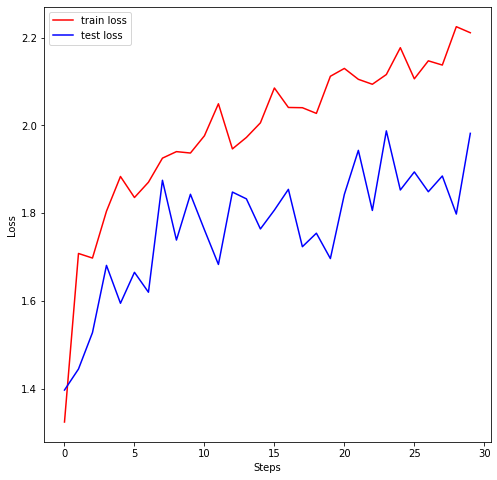

In [22]:
plt.figure(figsize=(8, 8))
plt.plot(losses, c='red', label='train loss')
plt.plot(test_losses, c='blue', label='test loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Fine tunning

Finally, we are going to fine tune our model unfreezing the top weights of the feature extractor

In [23]:
model.load_state_dict(torch.load(f"{MODEL_DIR}best-b3_siamese.pt"))

for parameter in model.features[7].parameters():
    parameter.requires_grad = True
for parameter in model.features[8].parameters():
    parameter.requires_grad = True

In [24]:
losses, test_losses, _, _ = train(
    model=model,
    train_set=train_loader,
    test_set=test_loader,
    epochs_=EPOCHS,
    step=siamese_train_step,
    learning_rate=0.0001,
    model_name="b3_siamese_finetuning",
    path_to_save=MODEL_DIR,
    patience=-1
)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 1.1409, Acc 0.0000 Test loss: 0.8311, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 0.8822, Acc 0.0000 Test loss: 0.6918, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.6933, Acc 0.0000 Test loss: 0.5718, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.5980, Acc 0.0000 Test loss: 0.4795, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.4952, Acc 0.0000 Test loss: 0.4295, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.4487, Acc 0.0000 Test loss: 0.3492, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.4097, Acc 0.0000 Test loss: 0.3227, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.3533, Acc 0.0000 Test loss: 0.2699, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.3225, Acc 0.0000 Test loss: 0.2472, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.2958, Acc 0.0000 Test loss: 0.2221, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.2735, Acc 0.0000 Test loss: 0.2139, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.2582, Acc 0.0000 Test loss: 0.2083, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.2405, Acc 0.0000 Test loss: 0.2093, Test acc: 0.0000 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.2406, Acc 0.0000 Test loss: 0.1985, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.2275, Acc 0.0000 Test loss: 0.1906, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.2148, Acc 0.0000 Test loss: 0.2042, Test acc: 0.0000 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.2231, Acc 0.0000 Test loss: 0.1782, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.2079, Acc 0.0000 Test loss: 0.1737, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.2162, Acc 0.0000 Test loss: 0.1784, Test acc: 0.0000 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.2065, Acc 0.0000 Test loss: 0.1754, Test acc: 0.0000 Epochs w/o improvement: 2


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.1985, Acc 0.0000 Test loss: 0.1558, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.1933, Acc 0.0000 Test loss: 0.1657, Test acc: 0.0000 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.1953, Acc 0.0000 Test loss: 0.1635, Test acc: 0.0000 Epochs w/o improvement: 2


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.1848, Acc 0.0000 Test loss: 0.1617, Test acc: 0.0000 Epochs w/o improvement: 3


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.1835, Acc 0.0000 Test loss: 0.1650, Test acc: 0.0000 Epochs w/o improvement: 4


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.1822, Acc 0.0000 Test loss: 0.1491, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.1836, Acc 0.0000 Test loss: 0.1527, Test acc: 0.0000 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.1779, Acc 0.0000 Test loss: 0.1559, Test acc: 0.0000 Epochs w/o improvement: 2


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.1801, Acc 0.0000 Test loss: 0.1425, Test acc: 0.0000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.1718, Acc 0.0000 Test loss: 0.1551, Test acc: 0.0000 Epochs w/o improvement: 1


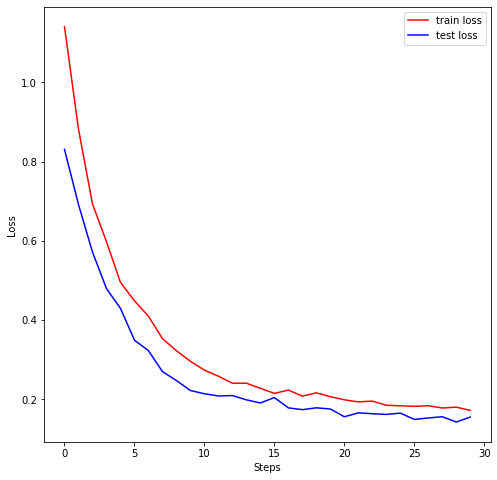

In [25]:
plt.figure(figsize=(8, 8))
plt.plot(losses, c='red', label='train loss')
plt.plot(test_losses, c='blue', label='test loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making the full model with the predictor

In [26]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.predictor = nn.Linear(in_features=1, out_features=1)
        
    def forward(self, image_1, image_2):
        image_1_features = self.base_model_model(image_1)
        image_2_features = self.base_model(image_2)
        
        dist = torch.linalg.norm(image_1_features - image_2_features, 2, dim=-1)
        
        return self.predictor(dist)

In [27]:
predictor_dataset = TripletCelebADataset('predictor', train_transforms)
predictor_dataloader_raw = DataLoader(
    train_dataset,
    BATCH_SIZE,
    shuffle=True,
    num_workers=14
)
predictor_dataloader = VirtualDataLoader(predictor_dataloader_raw, TRAIN_STEPS_PER_EPOCH)
model.load_state_dict(torch.load(f"{MODEL_DIR}best-b3_siamese_finetuning.pt"))
siamese = SiameseNetwork(model).to(device)

for parameter in siamese.base_model.parameters():
    parameter.requires_grad = False

In [28]:
def get_accuracy(predictions, labels):
    predicted_classes = np.clip(np.sign(predictions), 0, 1)
    return accuracy_score(labels, predicted_classes)

In [29]:
def predictor_train_step(model, anchor, positive, negative):
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)
    
    anchor_features = model.base_model(anchor)
    positive_features = model.base_model(positive)
    negative_features = model.base_model(negative)
    
    positives_distances = torch.linalg.norm(anchor_features - positive_features, 2, dim=-1) \
        .unsqueeze(1)
    negative_distances = torch.linalg.norm(anchor_features - negative_features, 2, dim=-1) \
        .unsqueeze(1)

    positives_predictions = model.predictor(positives_distances)
    negatives_predictions = model.predictor(negative_distances)
    
    positives_labels = torch.ones_like(positives_predictions)
    negatives_labels = torch.zeros_like(negatives_predictions)
    
    positive_loss = F.binary_cross_entropy_with_logits(positives_predictions, positives_labels)
    negative_loss = F.binary_cross_entropy_with_logits(negatives_predictions, negatives_labels)
    
    loss = 0.5 * (positive_loss + negative_loss)
    
    positive_accuracy = get_accuracy(
        positives_predictions.detach().cpu().numpy(),
        positives_labels.detach().cpu().numpy()
    )
    
    negative_accuracy = get_accuracy(
        negatives_predictions.detach().cpu().numpy(),
        negatives_labels.detach().cpu().numpy()
    )
    
    accuracy = 0.5 * (positive_accuracy + negative_accuracy)

    return loss, accuracy

In [30]:
losses, test_losses, accuracies, test_accuracies = train(
    model=siamese,
    train_set=predictor_dataloader,
    test_set=test_loader,
    epochs_=EPOCHS,
    step=predictor_train_step,
    learning_rate=0.001,
    model_name="b3_with_predictor",
    path_to_save=MODEL_DIR,
    patience=-1
)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1/30, Loss: 0.8349, Acc 0.5000 Test loss: 0.7082, Test acc: 0.5000 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2/30, Loss: 0.6858, Acc 0.5000 Test loss: 0.6469, Test acc: 0.5157 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3/30, Loss: 0.6359, Acc 0.5476 Test loss: 0.5807, Test acc: 0.8512 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4/30, Loss: 0.5829, Acc 0.7491 Test loss: 0.5214, Test acc: 0.8655 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5/30, Loss: 0.5353, Acc 0.8275 Test loss: 0.4726, Test acc: 0.8576 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6/30, Loss: 0.4956, Acc 0.8458 Test loss: 0.4411, Test acc: 0.8402 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7/30, Loss: 0.4637, Acc 0.8494 Test loss: 0.4157, Test acc: 0.8391 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8/30, Loss: 0.4366, Acc 0.8516 Test loss: 0.3971, Test acc: 0.8360 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9/30, Loss: 0.4185, Acc 0.8521 Test loss: 0.3892, Test acc: 0.8287 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10/30, Loss: 0.4024, Acc 0.8508 Test loss: 0.3695, Test acc: 0.8377 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11/30, Loss: 0.3894, Acc 0.8520 Test loss: 0.3619, Test acc: 0.8361 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12/30, Loss: 0.3806, Acc 0.8530 Test loss: 0.3670, Test acc: 0.8336 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13/30, Loss: 0.3674, Acc 0.8563 Test loss: 0.3608, Test acc: 0.8347 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14/30, Loss: 0.3655, Acc 0.8511 Test loss: 0.3524, Test acc: 0.8386 Epochs w/o improvement: 0


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15/30, Loss: 0.3624, Acc 0.8513 Test loss: 0.3600, Test acc: 0.8340 Epochs w/o improvement: 1


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16/30, Loss: 0.3542, Acc 0.8528 Test loss: 0.3658, Test acc: 0.8323 Epochs w/o improvement: 2


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17/30, Loss: 0.3525, Acc 0.8526 Test loss: 0.3623, Test acc: 0.8331 Epochs w/o improvement: 3


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18/30, Loss: 0.3496, Acc 0.8529 Test loss: 0.3684, Test acc: 0.8294 Epochs w/o improvement: 4


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19/30, Loss: 0.3458, Acc 0.8555 Test loss: 0.3603, Test acc: 0.8350 Epochs w/o improvement: 5


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20/30, Loss: 0.3490, Acc 0.8510 Test loss: 0.3764, Test acc: 0.8270 Epochs w/o improvement: 6


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21/30, Loss: 0.3437, Acc 0.8535 Test loss: 0.3680, Test acc: 0.8335 Epochs w/o improvement: 7


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22/30, Loss: 0.3381, Acc 0.8562 Test loss: 0.3580, Test acc: 0.8381 Epochs w/o improvement: 8


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23/30, Loss: 0.3398, Acc 0.8532 Test loss: 0.3708, Test acc: 0.8284 Epochs w/o improvement: 9


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24/30, Loss: 0.3416, Acc 0.8515 Test loss: 0.3605, Test acc: 0.8366 Epochs w/o improvement: 10


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25/30, Loss: 0.3413, Acc 0.8523 Test loss: 0.3724, Test acc: 0.8346 Epochs w/o improvement: 11


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26/30, Loss: 0.3410, Acc 0.8501 Test loss: 0.3804, Test acc: 0.8262 Epochs w/o improvement: 12


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27/30, Loss: 0.3389, Acc 0.8521 Test loss: 0.3631, Test acc: 0.8366 Epochs w/o improvement: 13


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28/30, Loss: 0.3365, Acc 0.8540 Test loss: 0.3739, Test acc: 0.8322 Epochs w/o improvement: 14


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29/30, Loss: 0.3341, Acc 0.8544 Test loss: 0.3794, Test acc: 0.8305 Epochs w/o improvement: 15


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Test:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 30/30, Loss: 0.3353, Acc 0.8545 Test loss: 0.3734, Test acc: 0.8349 Epochs w/o improvement: 16


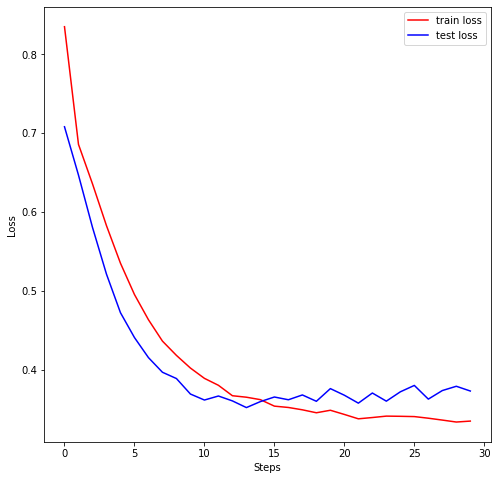

In [31]:
plt.figure(figsize=(8, 8))
plt.plot(losses, c='red', label='train loss')
plt.plot(test_losses, c='blue', label='test loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(accuracies, c='red', label='train accuracy')
plt.plot(test_accuracies, c='blue', label='test accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()